In [1]:
import numpy as np
import pandas as pd

import contractions
import re
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from src.features.build_features import preprocess_text, lemmatize_with_postags, remove_missing_reviews
from src.utilities.utilities import text_statistics, token_statistics

from pandarallel import pandarallel
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
pandarallel.initialize()

/Users/jensen/Desktop/recommendation-systems/projects/product-reviews-recommender/.venv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# setting some CONSTANTs
plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",   # specify font family here
    "font.serif": ["Palatino"],  # specify font here
    "font.size":12})

# Exploratory Text Pre-processing

In [3]:
CATEGORY = "Pet_Supplies"

In [4]:
# load dataset
products = pd.read_csv(f"data/interim/{CATEGORY}_merged.csv")

# check first 5 rows
products.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime
0,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A14CK12J7C7JRK,3.0,I purchased the Trilogy with hoping my two cat...,"01 12, 2011"
1,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A39QHP5WLON5HV,5.0,There are usually one or more of my cats watch...,"09 14, 2013"
2,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2CR37UY3VR7BN,4.0,I bought the triliogy and have tested out all ...,"12 19, 2012"
3,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2A4COGL9VW2HY,4.0,My female kitty could care less about these vi...,"05 12, 2011"
4,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2UBQA85NIGLHA,3.0,"If I had gotten just volume two, I would have ...","03 5, 2012"


## 1. Review Text Characteristics

### What is the min/max and average review length?

In [5]:
text_statistics(products, 'reviewText')

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 15622 characters, 2652 words.
Mean `reviewText` length: 458.63 characters, 87.44 words.
Median `reviewText` length: 298.0 characters, 58.0 words.


## 2. Text Pre-processing

### Expanding Contractions

In [6]:
products["processedReviewText"] = products["reviewText"].parallel_apply(lambda x: contractions.fix(x))

In [7]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 15634 characters, 2656 words.
Mean `reviewText` length: 460.72 characters, 88.91 words.
Median `reviewText` length: 300.0 characters, 59.0 words.


In [8]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['My little Maltese loves this.  I put food into each one and cover it up.  He loves to push the circles off the holes to get to the food.  It is great for a picky eater.  He thinks it is fun and eats!  It would also be good for a fast eater to slow them down.', "When our cat was a kitten she LOVED the 'Turbo Scratcher'. Over the years she is worn out the pads.These pads are a perfect fit!I periodically sprinkle catnip underneath the pad.We also use the lighted 'StarChaser Replacement Ball' in the Turbo Toy which helps capture kitty's attention :)", 'Well first off the little black grips that go over the wire ends to keep from scratching the well always fall off. I gave up and just put a little tape over the sharp edge. Second my cats are able to break the mouse from the string easily and do so about once a week. I re attach the toy part by tying the strings back together. That being said the cats freaking love this thing. I would give it five stars if it were not so irritating to have

### Removing Special Characters

In [9]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: " ".join(str(x).splitlines()))
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: re.sub(r"[^a-zA-Z]+", ' ', x.lower()))

In [10]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 14681 characters, 2672 words.
Mean `reviewText` length: 446.29 characters, 89.14 words.
Median `reviewText` length: 291.0 characters, 59.0 words.


In [11]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['i bought this to give my guinea pigs a change from timothy hay they loved it ate it up very quickly got excited and whistled and popcorned when i was filling the hay ball even liked eating it from my hand guinea pigs should only eat timothy hay or orchard grass i am very happy that this is available to keep their diet from getting monotonous ', 'i gave this ball to a friend who has a great dane pup and she loves it big dogs need big toys and toys that they cannot destroy in short order are hard to find this is the right size for her and as tough as she is ', 'though this product is well made and attractive it is definitely not small i have a canary who never uses it because it is so big and bulky ', 'dogs love this chew toy its thier favorite there is a squeeker in it also which makes it even better ', 'my gerbil inky loves this cage and i do too but for a few reasons i do not good stuff gerbil loved cagei do not have to clean petting zone often inky does not use it muchwater bottle 

### Lower Case

In [12]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: x.lower())

In [13]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 14681 characters, 2672 words.
Mean `reviewText` length: 446.29 characters, 89.14 words.
Median `reviewText` length: 291.0 characters, 59.0 words.


In [14]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['well the cats love the juice the veggies and the very small turkey bits but the chunks of turkey get left on the plates and thrown away is it just my cats or do most cats like a finer grind i would like to give this a higher rating because of the ingredients but the waste tarnishes that opinion ', 'i bought this for my cat because he grew out of his old one it is cute and very durable ', 'i replied to another review about these types of toys prior to receiving this skunk giving this brand a very positive review in my reply to another customer s review when the skunk arrived i was shocked at the poor quality of the toy immediately i went to my dog s folder and pulled out the cardboard that had been attached to her fox and her raccoon that is when i realized that this was not the same brand that i had previously purchased her toys are by a company called crazy critters i purchased it at meijers a super grocery store and the cardboard indicates in a red box in the upper right hand corne

### Lemmatization

In [15]:
def lemmatize_with_postags(sentence):
    """Lemmatize a given sentence based on given POS tags.
        Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#comparingnltktextblobspacypatternandstanfordcorenlp

    Args:
        sentence ([type]): [description]

    Returns:
        [type]: [description]
    """
    sent = TextBlob(sentence)
    tag_dict = {"J": "a", "N": "n", "V": "v", "R": "r"}
    words_and_tags = [(w, tag_dict.get(pos[0], "n")) for w, pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]

    return " ".join(lemmatized_list)

In [16]:
%%time
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: lemmatize_with_postags(x))

CPU times: user 232 ms, sys: 294 ms, total: 527 ms
Wall time: 2min 29s


In [17]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 13993 characters, 2673 words.
Mean `reviewText` length: 428.19 characters, 89.23 words.
Median `reviewText` length: 278.0 characters, 59.0 words.


In [18]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['this be one of the few chew toy my lab can not destroy she give it the old college try but could not rip it to shred needless to say i be happy', 'item a described i have be use this product on my dog for a long time and they have not have an ear infection since i start use it be recommend by my vet good investment', 'i buy a bag of the sojos dog food for my golden retriever on amazon recently and on a whim pick up a tin of catnip for some friend who be visit from out of town their cat be senior and have try many type of catnip over the year this be an excerpt of the e mail i receive from my friend when they get home and give their cat the sojos catnip i have never see the cat respond to catnip the way they do to the tin you give me they be fight over it like i have just lay out a tray of mouse and still wriggle tuna i have to get out a second plate just to keep the yowl down and after they go outside and roll in the dirt for several hour purr and completely stone i bring a plate out

### Remove Stop Words

In [19]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: remove_stopwords(x))

In [20]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 0 characters, 0 words.
Maximum `reviewText` length: 8449 characters, 1302 words.
Mean `reviewText` length: 211.34 characters, 34.45 words.
Median `reviewText` length: 134.0 characters, 22.0 words.


In [21]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['cat sleep night mind crinkly fabric inside use snuggle safe snuggle safe stay warmer longer underneath pad help warm pad', 'use john deere gator dog spill drive uneven ground', 'young cat slow harassment old sickly cat work hard litter box water bowl thing pheromone oil stuff foot maybe foot think ran completely spray final jet foot room lever slow consumption week month want replace heater month calm kitty worth', 'chat love toy buy cat pretty fast cat use time fast ship thank', 'exactly look litterbox large cage cage come thank goodness fit opening rabbit issue use right away negative fact like chew hole chew throw negative choose color definitely buy', 'cute t shirt fit great hard time buying clothes lab fit perfect', 'little skeptical day def reduce odor cat box end week odor nearly chemical smell detect def', 'okay item use difference buy item price sell local store animal like arrive day scent okay', 'cat bath smell great sure clean kitty apply bath groom mit use regular brush 

### Tokenization

In [22]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: simple_preprocess(x, deacc=True))

In [23]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

[['dog', 'thing', 'come', 'apart', 'second', 'toss', 'trash', 'big', 'disappointment'], ['dog', 'big', 'fan', 'saddle', 'pack', 'great', 'carry', 'stuff', 'hike'], ['customer', 'service', 'outstanding', 'spelling', 'error', 'quickly', 'correct', 'new', 'tag', 'send', 'tag', 'high', 'quality', 'long', 'time', 'golden', 'prefer', 'round', 'shape', 'bone', 'shape', 'previously', 'think', 'comfortable', 'collar', 'bone', 'company', 'plastic', 'mere', 'month', 'illegible', 'highly', 'recommend', 'item', 'look', 'quality', 'safety', 'furry', 'friend'], ['work', 'sufficiently', 'smell', 'improve', 'star', 'room', 'rug', 'leave', 'closed', 'definitely', 'notice', 'smell', 'walk', 'fortunately', 'problem', 'area', 'rug', 'bring', 'outside', 'wash', 'hop', 'easy', 'solution', 'smell', 'try', 'eventually', 'smell', 'totally', 'rinse', 'rug', 'use', 'vinegar', 'let', 'dry', 'hot', 'sun', 'couple', 'time', 'smell', 'surprise', 'rug', 'look', 'good', 'rougher', 'foot', 'failure', 'spray', 'suppose',

### Combining Tokens Into Pre-processed Reviews

In [24]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: ' '.join(x))

In [25]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 0 characters, 0 words.
Maximum `reviewText` length: 8335 characters, 1245 words.
Mean `reviewText` length: 210.62 characters, 34.14 words.
Median `reviewText` length: 134.0 characters, 22.0 words.


In [26]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['dog love chew month energy good year old benefit satisfied order product', 'lb papillion love tennis ball small chuck ball launcher play fetch barely fit mouth saw bring home love small tiny mouth beware big choke hazard throw far outdoor use love squeaky sound absolutely adore chase inside house time fell asleep mouth away ok maybe lol pretty sturdy rip felt ball happy important', 'dog enjoy toy love pull treat middle fun good', 'cheap method replace cartridge simple extra need definitely buy', 'receive package canine plus senior bite size chew immediately begin dog year old year old year old want particular old especially year old bit picky eat chew hard like geriatric chew small smell bit like vitamin love recommend pound dog weigh chew daily like want understand treat appetizing chicken liver flavor appeal bone shape dog know bone shape factor think dog owner buy product long list ingredient bag bromelain counter bladder drug contains bromelain relaxation help senior dog feel not

### Removing Empty Reviews

Post pre-processing, we observed that the minimum characters and words of a review is 0. This indicates some reviews which are short to begin with, will get pruned after the series of pre-processing. Hence, we will remove such reviews.

In [27]:
products = remove_missing_reviews(products, "processedReviewText")

In [28]:
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 8335 characters, 1245 words.
Mean `reviewText` length: 210.63 characters, 34.14 words.
Median `reviewText` length: 134.0 characters, 22.0 words.


In [29]:
# check shape
print(f"Rows: {products.shape[0]}, Columns: {products.shape[1]}.")

Rows: 111623, Columns: 10.


In [30]:
# check last 5 rows and their index
products.tail()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText
111618,B00KMHKOZC,Pet Magasin Retractable Dog Leash - Durable Do...,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",A136YD08SCJ2LV,5.0,The Pet Magasin Retractable Dog Leash is the b...,"07 14, 2014",299,46,pet magasin retractable dog leash best use lik...
111619,B00KMHKOZC,Pet Magasin Retractable Dog Leash - Durable Do...,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",A2YKWYC3WQJX5J,5.0,I'm not the biggest fan of retractable leashes...,"07 14, 2014",300,44,big fan retractable leash certain circumstance...
111620,B00KMHKOZC,Pet Magasin Retractable Dog Leash - Durable Do...,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",A2K0D19N83G6U2,4.0,I was provided a leash for my unbiased review....,"07 22, 2014",681,119,provide leash unbiased review lb lhasa apso us...
111621,B00KMHKOZC,Pet Magasin Retractable Dog Leash - Durable Do...,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",A3A4ZAIBQWKOZS,5.0,This is a well designed leash that offers the ...,"07 18, 2014",323,50,design leash offer flexi style retraction flex...
111622,B00KMHKOZC,Pet Magasin Retractable Dog Leash - Durable Do...,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",A1ITRGMT80D5TK,4.0,This leash is stated to be good for dogs up to...,"07 14, 2014",785,135,leash state good dog pound chihuahuas weigh po...


# Pre-processing Demonstration

In [31]:
# load dataset
products_demo = pd.read_csv(f"data/interim/{CATEGORY}_merged.csv")

# check first 5 rows
products_demo.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime
0,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A14CK12J7C7JRK,3.0,I purchased the Trilogy with hoping my two cat...,"01 12, 2011"
1,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A39QHP5WLON5HV,5.0,There are usually one or more of my cats watch...,"09 14, 2013"
2,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2CR37UY3VR7BN,4.0,I bought the triliogy and have tested out all ...,"12 19, 2012"
3,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2A4COGL9VW2HY,4.0,My female kitty could care less about these vi...,"05 12, 2011"
4,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2UBQA85NIGLHA,3.0,"If I had gotten just volume two, I would have ...","03 5, 2012"


In [32]:
n_random_products = products_demo.sample(10)

In [33]:
n_random_products["processedReviewText"] = n_random_products["reviewText"].progress_apply(lambda x: preprocess_text(x))

100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.35it/s]


In [34]:
n_random_products

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,processedReviewText
71058,B001F0RRUA,PetSafe Busy Buddy Kibble Nibble Meal Dispensi...,"['Pet Supplies', 'Dogs', 'Toys', 'Chew Toys']",A3III07Y9VJI8Q,4.0,"My dog loves this toy, but I only use it when ...","07 15, 2011",dog love toy use leave house noise tile wood f...
53111,B000K9JRH8,"GoCat DaBird Feather Refill, Assorted Colors, ...","['Pet Supplies', 'Cats', 'Toys', 'Feather Toys']",A1HKB0CZ226VFF,5.0,My cats love DaBird! I was so pleased to find ...,"03 10, 2014",cat love dabird pleased refill reasonable pric...
48670,B000FPJ78Q,"Dingo Goof Balls, Rawhide Chews Made With Real...","['Pet Supplies', 'Dogs', 'Treats', 'Rawhide', ...",A2EVG1OUG840JQ,5.0,"She plays with them a little, eats the meaty p...","09 1, 2011",play little eat meaty way enjoyment normal raw...
71834,B001FNZG96,goDog Dragons With Chew Guard Technology Durab...,"['Pet Supplies', 'Dogs', 'Toys']",A1C96WFS5J3EGD,4.0,I got this for my puppy a year ago and she lov...,"08 23, 2011",puppy year ago love death sleep carry apartmen...
102731,B007CRF1A8,Nature's Miracle Intense Defense Clumping Litter,"['Pet Supplies', 'Cats', 'Litter & Housebreaki...",A14I6MXBSI0BX,5.0,Just bought this litter on sale at petsmart la...,"09 19, 2012",buy litter sale petsmart week try wow actually...
55933,B000O00E6G,PetSafe Martingale Dog Collar Quick Snap Buckle,"['Pet Supplies', 'Dogs', 'Collars, Harnesses &...",AX8RL03LVZG1E,5.0,These collars are specifically great for dogs ...,"03 15, 2014",collar specifically great dog pull jump sit tr...
44627,B000BO3DZE,Petstages Mini Loop Ball,"['Pet Supplies', 'Dogs', 'Toys', 'Balls']",A2XYNWW23PAN1Z,5.0,"This is very small, so if you have a larger pu...","05 4, 2014",small large puppy work mini doxie perfect perf...
13165,B0002AQCXM,Zoo Med Deluxe Porcelain Clamp Lamp,"['Pet Supplies', 'Reptiles & Amphibians', 'Ter...",A2EAW9C31JE4L6,5.0,I tried a couple different heating mats for se...,"06 21, 2014",try couple different heating mat seed tank hea...
64414,B0015QC4P2,"Suncast Elevated Feeding Tray, Small","['Pet Supplies', 'Dogs', 'Feeding & Watering S...",A2JZIXBDRW4C5G,5.0,I got this because my girlfriend had one for h...,"09 10, 2008",girlfriend dog apartment tell dog want right l...
508,B0000632T8,KONG Teddy Bear Dog Toy,"['Pet Supplies', 'Dogs', 'Toys', 'Squeak Toys']",A3UCXYEAV06AHA,5.0,My first dog loved this toy as soon as I took ...,"06 13, 2011",dog love toy soon box aggressive chewer worry ...


In [35]:
print("Review text pre-processing, before vs. after: ")
before = n_random_products["reviewText"].values.tolist()
after = n_random_products["processedReviewText"].values.tolist()

for i in zip(before, after):
    print(f"Before: {i[0]}")
    print(f"After: {i[1]}\n")

Review text pre-processing, before vs. after: 
Before: My dog loves this toy, but I only use it when I'm leaving the house. She makes so much noise with it in my tile and wood floor home. If I have to leave around feeding time, I put her cup of food in here and leave it along with her usual kongs. I usually find it in my closet with one or two kibbles left inside when I get home.
After: dog love toy use leave house noise tile wood floor home leave feeding time cup food leave usual kongs usually closet kibble leave inside home

Before: My cats love DaBird! I was so pleased to find refills at a reasonable price because the feathers always eventually fall out of the red cap holding them to the string.
After: cat love dabird pleased refill reasonable price feather eventually fall red cap hold string

Before: She plays with them a little, eats the meaty parts, and gets way more enjoyment than she ever does from just a normal rawhide. Less time for chewing, but more time for playing.
After: 

# Data Visualization

In [36]:
text_statistics(products, "reviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 15622 characters, 2652 words.
Mean `reviewText` length: 458.65 characters, 87.44 words.
Median `reviewText` length: 298.0 characters, 58.0 words.


In [37]:
products.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText
0,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A14CK12J7C7JRK,3.0,I purchased the Trilogy with hoping my two cat...,"01 12, 2011",590,116,purchase trilogy hop cat age interested yr old...
1,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A39QHP5WLON5HV,5.0,There are usually one or more of my cats watch...,"09 14, 2013",217,44,usually cat watch tv stay trouble dvd play lik...
2,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2CR37UY3VR7BN,4.0,I bought the triliogy and have tested out all ...,"12 19, 2012",412,81,buy triliogy test dvd appear volume receive re...
3,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2A4COGL9VW2HY,4.0,My female kitty could care less about these vi...,"05 12, 2011",288,57,female kitty care video care little male dig a...
4,1223000893,"Cat Sitter DVD Trilogy - Vol 1, Vol 2 and Vol 3",[],A2UBQA85NIGLHA,3.0,"If I had gotten just volume two, I would have ...","03 5, 2012",888,171,volume star trilogy star read review know vol ...


In [38]:
products["processedReviewWordLength"] = products["processedReviewText"].apply(lambda x: len(x.split()))

In [39]:
def plot_distributions(df, cols=['reviewWordLength', 'processedReviewWordLength']):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
    fig.suptitle(f"Comparison of Review Words Distribution Before and After Pre-processing", y=0.925, verticalalignment='bottom')
    for idx, col in enumerate(cols):
        ax = sns.histplot(df[col], ax=axes[idx], bins=100, binwidth=10)
        ax.set_xlim(0,500)
    
    plt.savefig(f"reports/figures/review_words_distribution.png", dpi=150)
    plt.show()

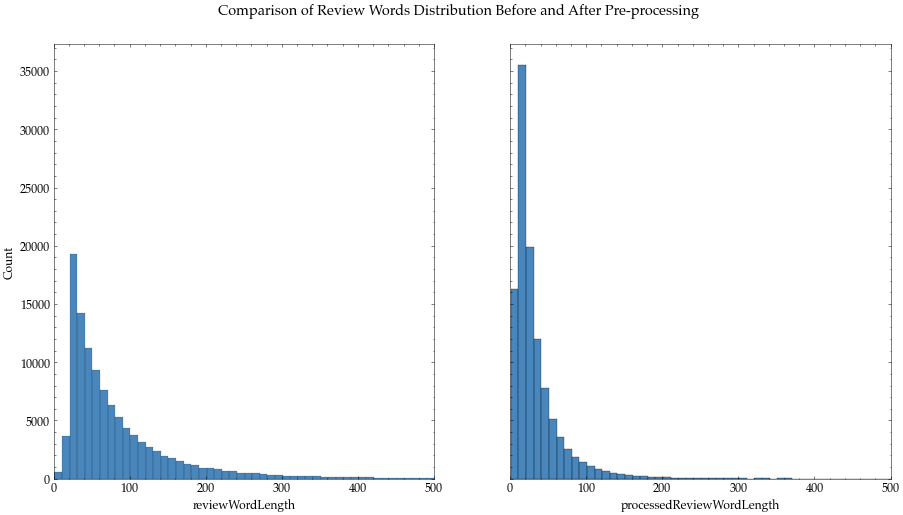

In [40]:
plot_distributions(products)

In [41]:
products.sort_values(by='processedReviewText', ascending=True, key=lambda x: x.str.len())

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText,processedReviewWordLength
56204,B000O5DI1E,Beef Pill Pockets Large 7.9oz,"['Pet Supplies', 'Dogs', 'Health Supplies', 'S...",AZ7HUXVHAFFKN,3.0,ok,"07 2, 2014",2,1,ok,1
7572,B000255OIG,Stewart Freeze Dried Treats 14 oz Beef Liver,"['Pet Supplies', 'Dogs', 'Treats', 'Cookies, B...",A19HDIOM7WGMFB,4.0,but the dogs can't get enough.,"07 8, 2014",30,6,dog,1
7465,B000255OIG,Stewart Freeze Dried Treats 14 oz Beef Liver,"['Pet Supplies', 'Dogs', 'Treats', 'Cookies, B...",A19HDIOM7WGMFB,4.0,but the dogs can't get enough.,"07 8, 2014",30,6,dog,1
14208,B0002AQM9Q,Vets Best Dog Hot Spot Itch Relief Spray | Soo...,"['Pet Supplies', 'Dogs', 'Health Supplies', 'I...",AOJA8QAE740LY,3.0,meh,"07 9, 2014",3,1,meh,1
14222,B0002AQM9Q,Vets Best Dog Hot Spot Itch Relief Spray | Soo...,"['Pet Supplies', 'Dogs', 'Health Supplies', 'I...",AOJA8QAE740LY,3.0,meh,"07 9, 2014",3,1,meh,1
...,...,...,...,...,...,...,...,...,...,...,...
9720,B00025K1GG,Hikari Freeze Dried Tubifex Worms,"['Pet Supplies', 'Fish & Aquatic Pets', 'Food']",A3BNVMPIHDYGNQ,5.0,Tubifex worms are usually gobbled up by most f...,"01 13, 2014",6736,973,tubifex worm usually gobble fish need protein ...,654
9738,B00025K1GG,Hikari Freeze Dried Tubifex Worms,"['Pet Supplies', 'Fish & Aquatic Pets', 'Food']",A3BNVMPIHDYGNQ,5.0,Tubifex worms are usually gobbled up by most f...,"01 13, 2014",6736,973,tubifex worm usually gobble fish need protein ...,654
104708,B008CA7W7E,Tetra LED Cube Shaped 3 Gallon Aquarium with P...,"['Pet Supplies', 'Fish & Aquatic Pets', 'Aquar...",AYXM55IJH5APV,2.0,"Now obviously this is quite a long review, but...","11 4, 2013",9672,1750,obviously long review try address question ask...,767
55340,B000MS6Q2Q,HDP Fleabusters Rx for Fleas Plus 3Lb Kills Ro...,"['Pet Supplies', 'Cats', 'Flea & Tick Control']",A1QCJOGQL05KRI,1.0,I had a bad flea problem last year after getti...,"12 10, 2007",12543,2346,bad flea problem year puppy year manage new dy...,786


In [42]:
# finding unique tokens for `preprocessedReviewText`
concat_tokens = ' '.join(products["processedReviewText"])
unique_tokens = len(set(concat_tokens.split()))
print(f"The number of unique tokens: {unique_tokens}")

The number of unique tokens: 44330


In [43]:
# finding unique tokens for `reviewText`
concat_tokens = ' '.join(products["reviewText"])
unique_tokens = len(set(concat_tokens.split()))
print(f"The number of unique tokens: {unique_tokens}")

The number of unique tokens: 231430


## Misc Test

In [44]:
review = products_demo.sample(1)['reviewText'].values[0]
print(review)

This comb does not work on DSH cats. The teeth are too far apart to be effective our flea comb works better


In [45]:
review = lemmatize_with_postags(review)
print(review)

This comb do not work on DSH cat The teeth be too far apart to be effective our flea comb work well


In [46]:
review = simple_preprocess(review, deacc=True)
print(review)

['this', 'comb', 'do', 'not', 'work', 'on', 'dsh', 'cat', 'the', 'teeth', 'be', 'too', 'far', 'apart', 'to', 'be', 'effective', 'our', 'flea', 'comb', 'work', 'well']


In [47]:
review_gensim = remove_stopwords(" ".join(review))
print(review_gensim)

comb work dsh cat teeth far apart effective flea comb work


In [48]:
review_nltk = " ".join([word for word in review if not word in stopwords.words()])
print(review_nltk)

comb work dsh teeth far apart effective flea comb work well
